# HORIBA PTI QuantaMaster800

Este notebook pretende dar un ejemplo del funcionamiento de la API para controlar el espectrómetro HORIBA PTI QuantaMaster800.

El funcionamiento es muy simple y consiste en los siguientes pasos:
1. Importar ```rpyc``` y crear la conexión con la Red Pitaya
1. Importar e inicializar ```Spectrometer``` con el constructor por defecto.
1. Llevar los monocromoadores a la posición inicial.
1. Medir espectro de emisión o de excitación.

En las primeras dos celdas escribo algunas configuraciones y funciones simples para graficar.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

Defino una función para plotear en tiempo real. Esta funcionalidad podría estar embebida en una aplicación.

In [2]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display, clear_output

def plot_spectrum(spec, **params):
    
    fig, ax = plt.subplots()
    spectrum_iterator = spec.get_emission(**params, iterator=True)
    line, = ax.plot([],[], '-o')
    ax.set_xlim(params["starting_wavelength"]-1, params["ending_wavelength"]-1)
    ax.set_ylim(0, 250)
    ax.grid()
    ax.set_title("Gráfico espectro")
    ax.set_xlabel("Longitud de onda (nm)")
    ax.set_ylabel("Cuentas")
    n_frames = int((params["ending_wavelength"] - params["starting_wavelength"])/params["wavelength_step"])

    def init():
        line.set_data([],[])
        return line,
        
    def update(frame):
        df = next(spectrum_iterator)
        x, y = df["wavelength"].iloc[:frame], df["counts"].iloc[:frame]
        line.set_data(x,y)
        clear_output(wait=True)
        display(fig)
        return line,

    ani = FuncAnimation(fig, update, frames=n_frames-1, repeat=False, interval=1000, init_func=init)
    plt.show()
    HTML(ani.to_jshtml())

    

Inicializamos la conexión y luego el espectrómetro.

In [3]:
import rpyc
from ucnpexp.instruments import Spectrometer

# Inicializamos conexión
conn = rpyc.connect("rp-f05512.local", port=18861)

#inicializamos espectrómetro
spec = Spectrometer.constructor_default(conn)

# Llevamos a los monocromadores a su posición inicial
spec.home()

Lamp wavelength should be 298
Monochromator wavelength should be 256.5
If they are wrong, set them with spec.lamp.set_wavelength() and spec.monochromator.set_wavelength()


Ahora podemos definir un diccionario con los parámetros de medición, y luego medir llamando a la función get_emission del espectrómetro (también se los podemos pasar directamente a la función). Esta función devuelve un DataFrame de pandas con los datos, que podemos visualizar usando ```display```.

In [4]:
params = {
    "integration_time":0.1,
    "starting_wavelength":300,
    "ending_wavelength":350,
    "wavelength_step":1,
    "excitation_wavelength":290
}
df = spec.get_emission(**params)
display(df)

,wavelength,counts,integration time
0,300.0,109,0.1
1,301.0,114,0.1
2,302.0,112,0.1
3,303.0,120,0.1
4,304.0,110,0.1
5,305.0,118,0.1
6,306.0,100,0.1
7,307.0,120,0.1
8,308.0,94,0.1
9,309.0,80,0.1


Con esto podemos graficar los datos e interactuar con el gráfico.

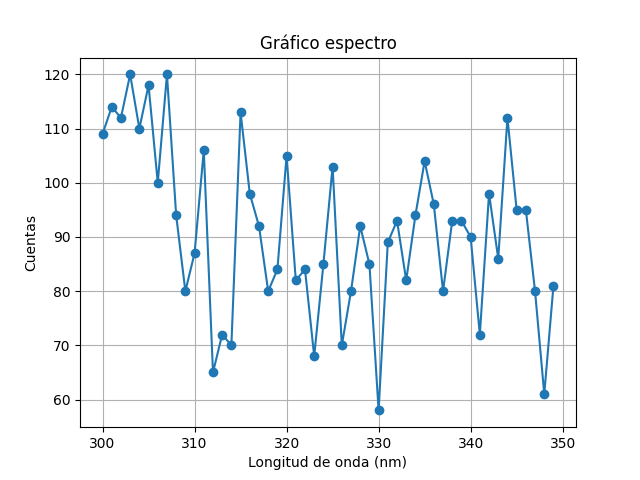

In [5]:
wls, counts = df["wavelength"], df["counts"]
plt.figure()
plt.plot(df["wavelength"], df["counts"], 'o-')
plt.grid()
plt.title("Gráfico espectro")
plt.xlabel("Longitud de onda (nm)")
plt.ylabel("Cuentas")
plt.show()

Ahora podemos guardar los datos en el formato que queramos con las funcionalidades de los DataFrames de Pandas

In [6]:
path = "/home/tomi/Desktop/datos_espectro.csv"
df.to_csv(path)

También podemos usar la función que escribí arriba pasando como parámetros al espectrómetro y al diccionario de parámetros de medición para ver cómo se forma el gráfico en tiempo real.

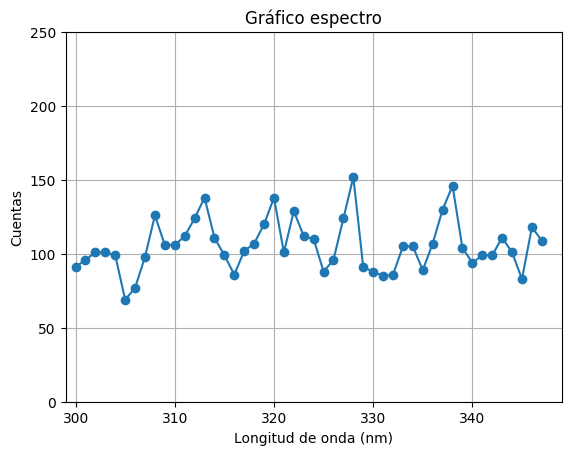

In [7]:
plot_spectrum(spec, **params)